# Predicting Bank Customer Churn

## Background

In this project, we intend to predict customer churn for a bank. Customer churn refers to the loss of customers or subscribers for any given reason. The data utilized was provided via [Kaggle](https://www.kaggle.com/datasets/shubhammeshram579/bank-customer-churn-prediction/data), and it contains information on bank customers who either left the bank in question or continue to be a customer.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')

In [2]:
## Loading the Data
df = pd.read_csv('./Churn_Modelling.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42.0,2,0.00,1,1.0,1.0,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41.0,1,83807.86,1,0.0,1.0,112542.58,0
2,3,15619304,Onio,502,France,Female,42.0,8,159660.80,3,1.0,0.0,113931.57,1
3,4,15701354,Boni,699,France,Female,39.0,1,0.00,2,0.0,0.0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43.0,2,125510.82,1,NaN,1.0,79084.10,0


The data contains the following attributes:

* Customer ID: A unique identifier for each customer
* Surname: The customer's surname or last name
* Credit Score: A numerical value representing the customer's credit score
* Geography: The country where the customer resides (France, Spain or Germany)
* Gender: The customer's gender (Male or Female)
* Age: The customer's age.
* Tenure: The number of years the customer has been with the bank
* Balance: The customer's account balance
* NumOfProducts: The number of bank products the customer uses (e.g., savings account, credit card)
* HasCrCard: Whether the customer has a credit card (1 = yes, 0 = no)
* IsActiveMember: Whether the customer is an active member (1 = yes, 0 = no)
* EstimatedSalary: The estimated salary of the customer
* Exited: Whether the customer has churned (1 = yes, 0 = no)


Let's get a view of the data via the .info() method.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10002 entries, 0 to 10001
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10002 non-null  int64  
 1   CustomerId       10002 non-null  int64  
 2   Surname          10002 non-null  object 
 3   CreditScore      10002 non-null  int64  
 4   Geography        10001 non-null  object 
 5   Gender           10002 non-null  object 
 6   Age              10001 non-null  float64
 7   Tenure           10002 non-null  int64  
 8   Balance          10002 non-null  float64
 9   NumOfProducts    10002 non-null  int64  
 10  HasCrCard        10001 non-null  float64
 11  IsActiveMember   10001 non-null  float64
 12  EstimatedSalary  10002 non-null  float64
 13  Exited           10002 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 1.1+ MB


Noticing we've got differing non-null counts. I'd like to work with a dataset without null values. Let's go ahead and drop them.

In [4]:
df.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          1
Gender             0
Age                1
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          1
IsActiveMember     1
EstimatedSalary    0
Exited             0
dtype: int64

Doesn't look like there's only a handful so we won't be losing that many rows' worth of information.

In [5]:
df.dropna(inplace=True)

In [6]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,9998.000000,9.998000e+03,9998.000000,9998.000000,9998.000000,9998.000000,9998.000000,9998.000000,9998.000000,9998.000000,9998.000000
mean,5003.497499,1.569094e+07,650.529606,38.920287,5.013003,76481.490819,1.530206,0.705541,0.514803,100099.786455,0.203841
std,2886.321275,7.192399e+04,96.633003,10.487986,2.892152,62393.187035,0.581669,0.455822,0.499806,57510.939962,0.402872
min,1.000000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,2504.250000,1.562854e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.000000,0.000000,50983.750000,0.000000
50%,5003.500000,1.569073e+07,652.000000,37.000000,5.000000,97173.290000,1.000000,1.000000,1.000000,100218.210000,0.000000
75%,7502.750000,1.575323e+07,718.000000,44.000000,7.000000,127641.417500,2.000000,1.000000,1.000000,149395.882500,0.000000
max,10000.000000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


In [7]:
df['Exited'].unique() #Making sure the Exited column, our target variable, doesn't have any funny business within it.

array([1, 0])

The model we'll build is meant to take our features and use them to predict our target variable, Exited.
I'll set up a dataframe with all our features and call it X. Our target variable in turn will be stored as a series y. However, I will strike RowNumber and CustomerId from X because these features have no plausible connection to our target variable.

In [8]:
X = df.iloc[:, 3:-1]
y = df['Exited']

In [9]:
X.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,France,Female,42.0,2,0.00,1,1.0,1.0,101348.88
1,608,Spain,Female,41.0,1,83807.86,1,0.0,1.0,112542.58
2,502,France,Female,42.0,8,159660.80,3,1.0,0.0,113931.57
3,699,France,Female,39.0,1,0.00,2,0.0,0.0,93826.63
5,645,Spain,Male,44.0,8,113755.78,2,1.0,0.0,149756.71


In [10]:
y.head()

0    1
1    0
2    1
3    0
5    1
Name: Exited, dtype: int64

In [11]:
X.dtypes

CreditScore          int64
Geography           object
Gender              object
Age                float64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard          float64
IsActiveMember     float64
EstimatedSalary    float64
dtype: object

Some of these data types don't align with our intuitive understanding of our features. IsActiveMember, for example, is a categorical variable rather than a numeric one. Let's go ahead and make some changes here, making sure data types align with our intuitive understanding of the features in question.

In [12]:
X['HasCrCard'] = X['HasCrCard'].astype('category')
X['IsActiveMember'] = X['IsActiveMember'].astype('category')
X['Age'] = X['Age'].astype('int64')
X['Geography'] = X['Geography'].astype('category')
X['Gender'] = X['Gender'].astype('category')

In [13]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9998 entries, 0 to 10001
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   CreditScore      9998 non-null   int64   
 1   Geography        9998 non-null   category
 2   Gender           9998 non-null   category
 3   Age              9998 non-null   int64   
 4   Tenure           9998 non-null   int64   
 5   Balance          9998 non-null   float64 
 6   NumOfProducts    9998 non-null   int64   
 7   HasCrCard        9998 non-null   category
 8   IsActiveMember   9998 non-null   category
 9   EstimatedSalary  9998 non-null   float64 
dtypes: category(4), float64(2), int64(4)
memory usage: 586.3 KB


## Exploratory Data Analysis

Let's explore the data a little bit and see if we can get a few preliminary insights from it.

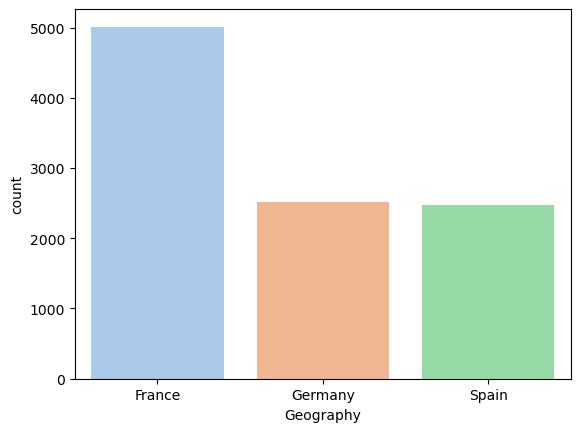

In [14]:
sns.countplot(X, x='Geography', palette='pastel');

Our dataset seems to only cover the European countries of France, Spain, and Germany, with France taking up roughly half of our dataset.

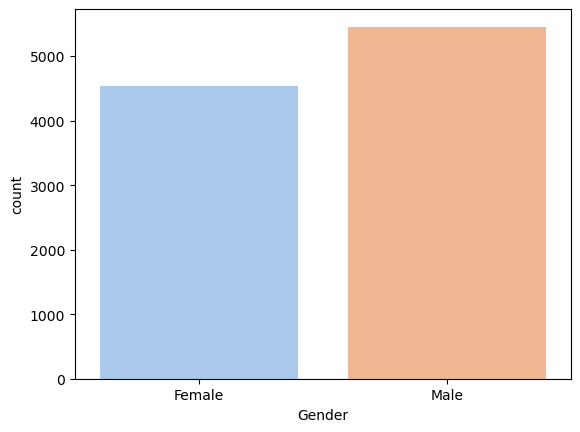

In [15]:
sns.countplot(X, x='Gender', palette='pastel');

Seems we're roughly evenly split on gender, with women in the slight minority.

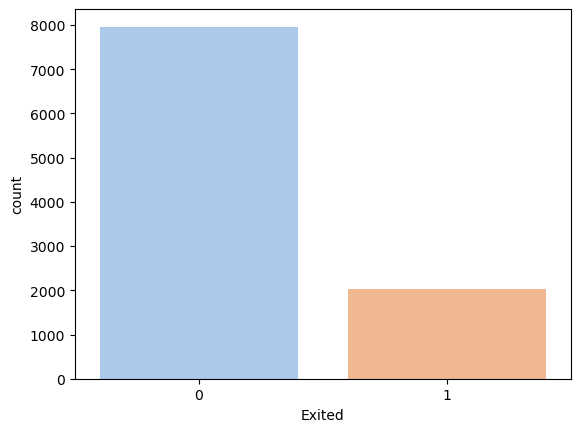

In [16]:
sns.countplot(x = df['Exited'], palette='pastel'); #avoiding using y here because it would look awkward

Eyeballing it, it looks like customer churn overall is somewhere on the order of about 20%

Do we have differing rates of exit among countries?

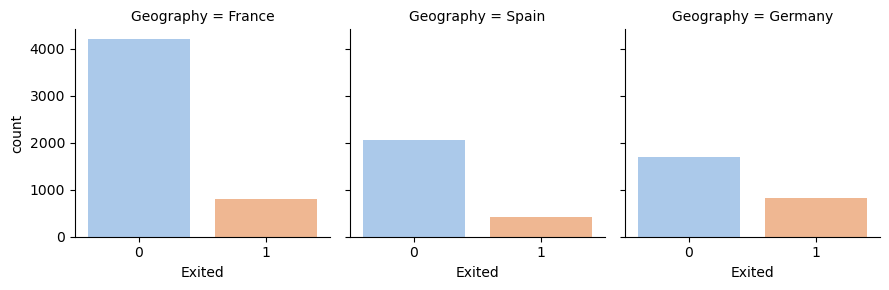

In [17]:
g = sns.FacetGrid(df, col='Geography')
g.map(sns.countplot, 'Exited', palette = 'pastel');

It seems that of the three countries observed, Germany's churn rate is the highest.

I wonder if there's differences beetween genders?

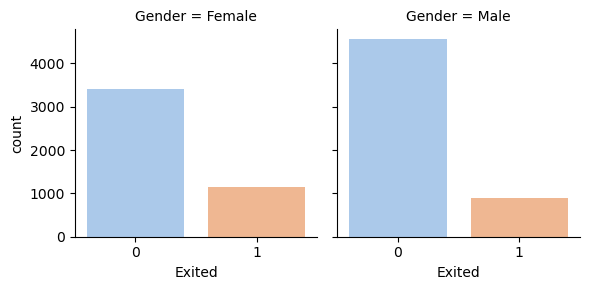

In [18]:
g = sns.FacetGrid(df, col='Gender')
g.map(sns.countplot, 'Exited', palette = 'pastel');

It seems that women have a marginally higher churn rate than men do.

Let's look at the distribution of tenure, and whether tenure has a particular effect on churn.

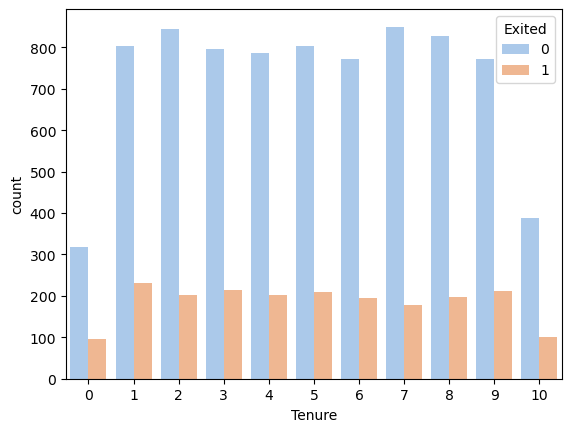

In [19]:
sns.countplot(X, x='Tenure', palette='pastel', hue=y);

Seems that tenure is roughly even distributed between year 1-9, with smaller numbers of people at <1 or >9 years of tenure. Another interesting tidbit is that churn rates are pretty similar throughout, but they tend to be proportionally higher for those with tenure at <1 or >9 years of tenure. This makes some intuitive sense. New customers might immediately find they do not like the banks' services and switch out, while older customers might seek new pastures after a while with their bank as their needs change over time. If you've been with the bank for over a year or so, chances are you're going to stick with it and hold to a standard churn rate.

In the description of the dataset we obtained via the .describe() method, we saw that the number of products a customer holds only goes up to about 4. Let's take a look if there's any difference in churn rates as a customer's products go from 1 -> 2 -> 3 -> 4.

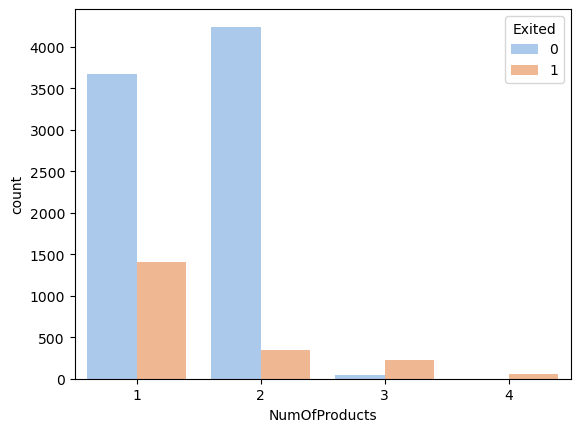

In [20]:
sns.countplot(X, x='NumOfProducts', palette='pastel', hue=y);

Something interesting seems to happen here. You might think that the number of products a customer has with the bank would have a negative correlation with the customer's respective probability of exiting (logic here being that the number of products taken on would serve as an indirect proxy of the customers' satisfaction with the bank), and that does seem to happen as the number of products goes from 1 to 2, but as soon as the customer takes on even more products, **the customer is actually more likely than not to exit**.

This makes some amount of sense as well. After all, we're talking about financial products. A customer that has taken on too many instruments at once might be exiting because they've botched their finances.

Who is buying how many products, however? Is there a differene between men and women?

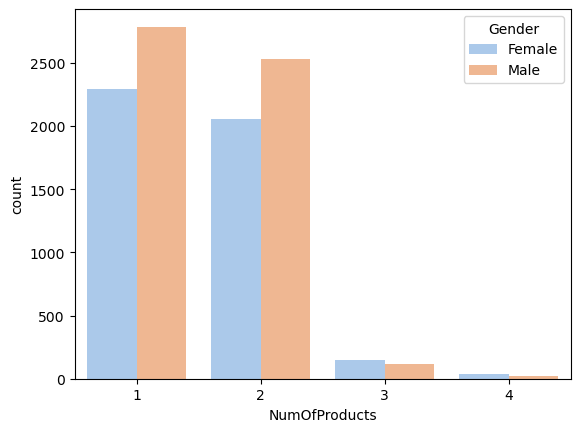

In [21]:
sns.countplot(X, x='NumOfProducts', palette='pastel', hue='Gender');

Looks like men are marginally over-represented in the 1-2 range, whereas women are marginally over-represented in the 3-4 range.

Is it the French, the Spanish, or Germans?

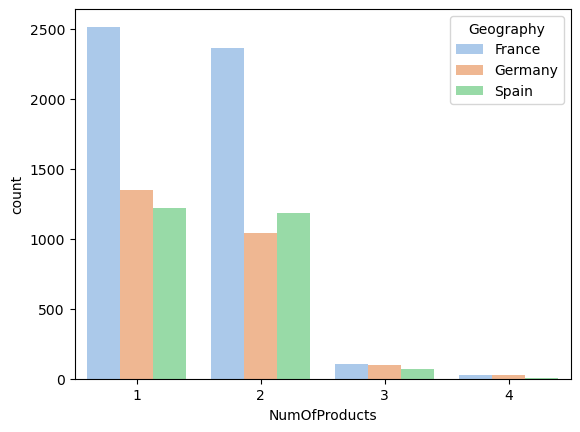

In [22]:
sns.countplot(X, x='NumOfProducts', palette='pastel', hue='Geography');

Seems like the three countries have similar product usage patterns. Overall, it also seems like there's just not that many people in the 3-4 product range.

Now let's look at credit card usage:

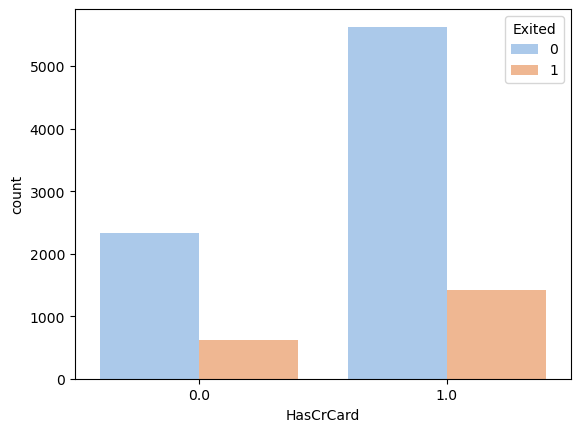

In [23]:
sns.countplot(X, x='HasCrCard', palette='pastel', hue=y);

Seems like customers without credit cards have a marginally higher chance of exiting. They might be disengaged or perhaps they lack credit cards due to poor credit - which in turn might be the fundamental reason that they're more likely to exit the bank.

Now let's do active members vs non-active members.

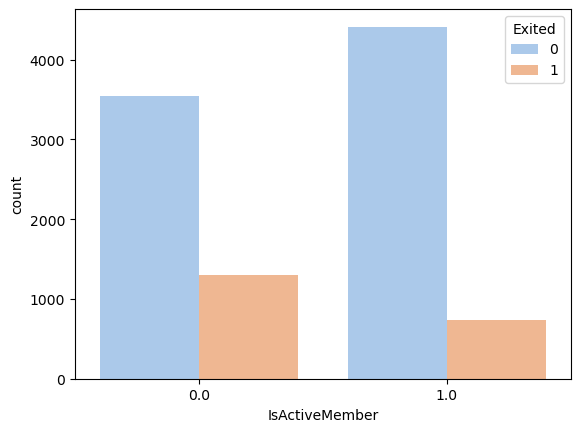

In [25]:
sns.countplot(X, x='IsActiveMember', palette='pastel', hue=y);

Intuitively, members that aren't active are more likely than not to exit the bank. They're not using its services, after all. Why would they stay?

I wonder if there's any relationship between estimated salary and whether or not someone exits. Let's track incomes across ages, and see how they compare between people who exited and people who stayed with the bank.

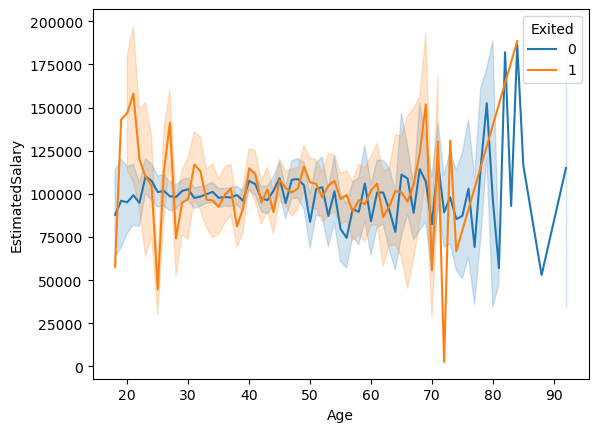

In [35]:
sns.lineplot(X, x='Age', y='EstimatedSalary', hue=y);

It seems that among those in their 20's, those people who exit the bank tend to have a higher income than those who don't. Then again, how many people in their 20's make high incomes? Perhaps it may be more informative to restrict ages to those ages where people tend to be working. Let's limit age from 25-65 years.

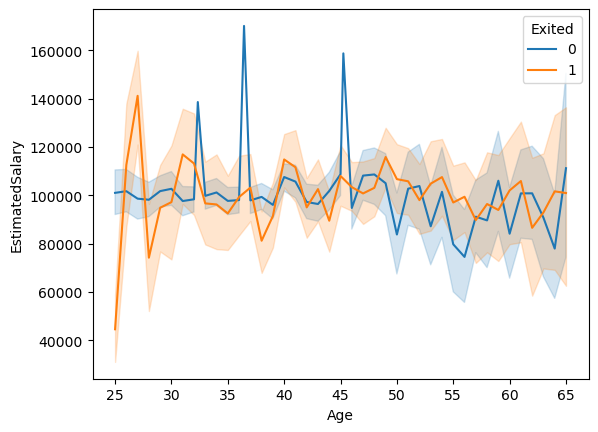

In [41]:
sns.lineplot(df[(df['Age'] >= 25) & (df['Age'] <= 65)], x='Age', y='EstimatedSalary', hue='Exited');

With the exception of a few spikes, there's generally no relationship between one's income and whether or not one exits the bank.

Is there a relationship between one's gender and one's available balance?

<Axes: xlabel='Balance', ylabel='Count'>

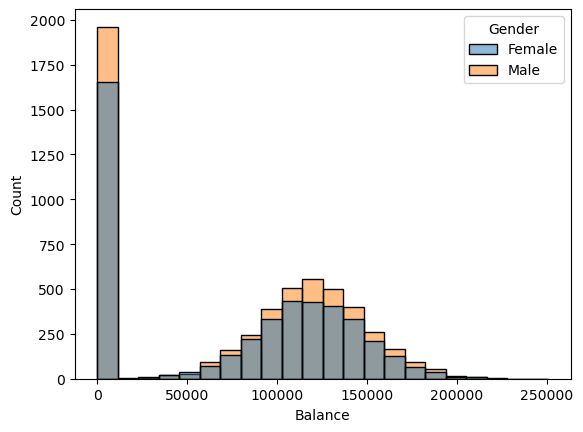

In [47]:
sns.histplot(X, x='Balance', hue='Gender')

Not that much of a difference in terms of their respective distributions but I was surprised to find a massive spike at the lower end. Bank balances seem to be normally distributed but there is a big segment of bank customers with accounts at 0.

In [64]:
X['Balance'].value_counts()

0.00         3616
130170.82       2
75075.31        2
105473.74       2
130142.79       2
             ... 
176024.05       1
107499.70       1
98807.45        1
136596.85       1
174126.75       1
Name: Balance, Length: 6379, dtype: int64

In [72]:
len(X[X['Balance'] == 0]) / len(X)

0.3616723344668934

Roughly a third of all those people in our dataset have bank balances at 0!

Now, surely those with bank balances at 0 must be at higher risk of exiting the bank?

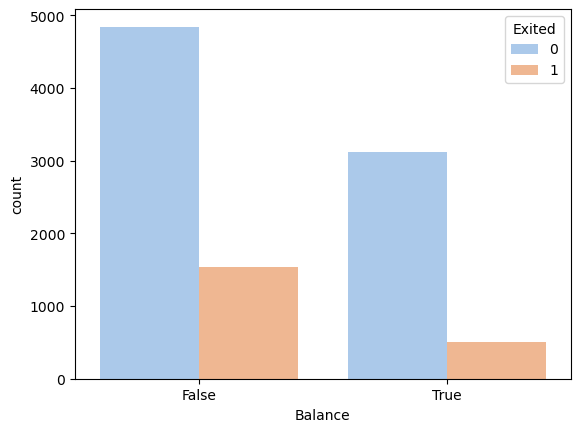

In [63]:
sns.countplot(x=(df['Balance'] == 0), palette='pastel', hue=df['Exited']);

Looks like that's somehow not the case! It seems those who have positive bank balances are marginally more likely than those who don't to leave the bank!

Who among the nations tends to have more in their bank balance?

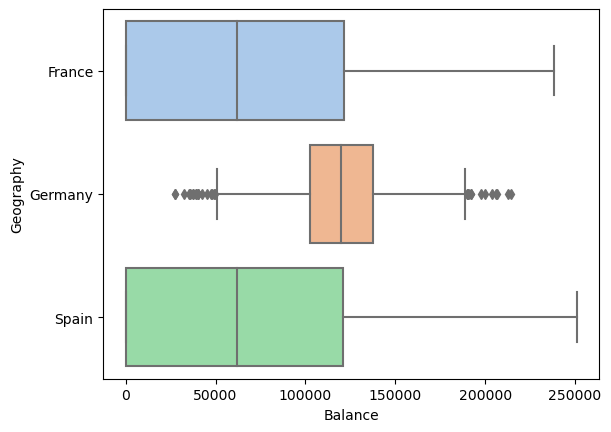

In [75]:
sns.boxplot(X, x='Balance', y='Geography', palette='pastel');

Looks like Germans tend to save more on average. Their range is also narrower than those of the French or Spanish. Now how about between the genders?

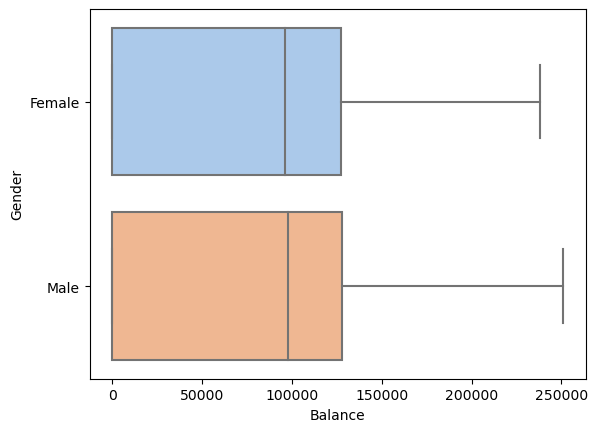

In [77]:
sns.boxplot(X, x='Balance', y='Gender', palette='pastel');

As was suggested by our earlier histogram, men and women tend to save roughly about as much.

## Synopsis of Insights
* Marginally higher number of men than women in the dataset.
* France makes up roughly 50% fo the dataset.
* Germany's churn rate tends to be higher than that of France and Spain.
* Those without credit cards have a marginally higher chance of leaving.
* Those customers who have taken on 3 or more product are more likely than not to leave the bank.
* Inactive members are marginally more likely to leave the bank.
* Nearly a third of all bank customers have their account balances at 0.
* Having a bank balance at 0 makes one marginally more likely to stay with the bank somehow.
* Germans tend to save more on average, though the range of their bank balances is also narrower compared to those of the French and the Spanish.


## Feature Engineering

At this juncture we will begin our modeling, starting off with feature engineering.
We'll first split our data into training and test sets by taking advantage of the sklearn libary.

In [78]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=42)

In [79]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9998 entries, 0 to 10001
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   CreditScore      9998 non-null   int64   
 1   Geography        9998 non-null   category
 2   Gender           9998 non-null   category
 3   Age              9998 non-null   int64   
 4   Tenure           9998 non-null   int64   
 5   Balance          9998 non-null   float64 
 6   NumOfProducts    9998 non-null   int64   
 7   HasCrCard        9998 non-null   category
 8   IsActiveMember   9998 non-null   category
 9   EstimatedSalary  9998 non-null   float64 
dtypes: category(4), float64(2), int64(4)
memory usage: 586.3 KB


In [80]:
numerical_cols = ['CreditScore', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'EstimatedSalary']
categorical_cols = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']

In [81]:
## Scaling numerical variables
scaler = StandardScaler()
X_train[numerical_cols]=scaler.fit_transform(X_train[numerical_cols])
X_val[numerical_cols]=scaler.transform(X_val[numerical_cols])

In [82]:
## Encoding categorical variables
encoder = OneHotEncoder(sparse=False, handle_unknown = 'ignore')
encoder.fit(X[categorical_cols])
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
X_train[encoded_cols] = encoder.transform(X_train[categorical_cols])
X_val[encoded_cols] = encoder.transform(X_val[categorical_cols])
## Dropping old categorical variables now that they have been encoded
X_train.drop(columns=categorical_cols, inplace=True)
X_val.drop(columns=categorical_cols, inplace=True)

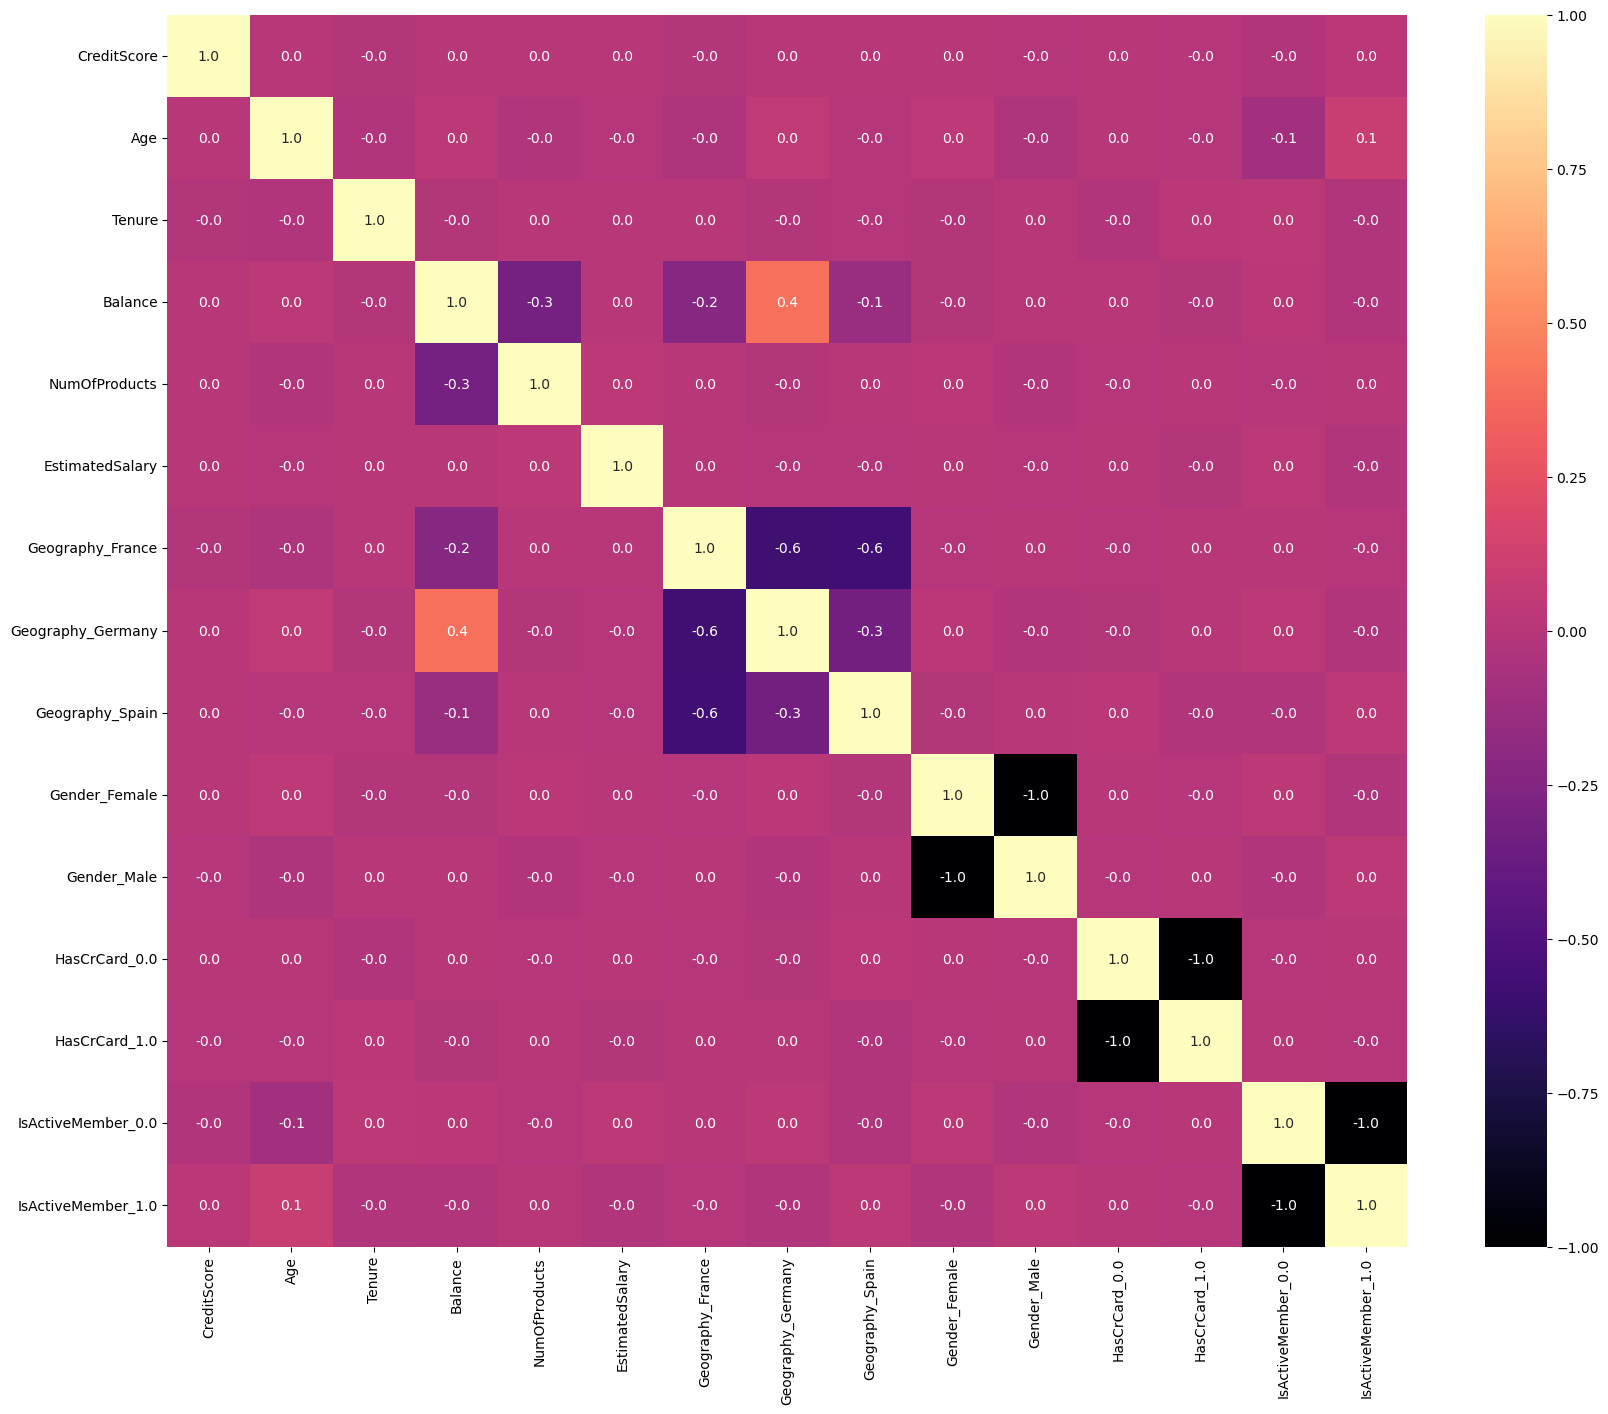

In [83]:
plt.figure(figsize=(20, 16))
sns.heatmap(X_train.corr(), annot=True, fmt='.1f', cmap='magma');

## XGBoost Model

In [90]:
model = xgb.XGBClassifier(random_state=42, jobs=-1)

In [91]:
params={
    "learning_rate":[0.05,0.1,0.2],
    "max_depth":[4,6,8,16],
    "n_estimators":[50,100,200,400],
    "subsample":[0.2,0.4,0.6,0.8],
    "gamma": [0, 0.25, 1.0]
}

In [92]:
grid_search = GridSearchCV(estimator=model, param_grid=params, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train);

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None, jobs=-1,
                                     learning_ra...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'gamma': [0, 0.25, 1.0],
                         'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [4, 6, 8, 16],
                         'n_estimators': [50, 100, 200, 400],
                         'subsample': [0.2, 0.4, 0.6, 0.8]},
             scoring='accuracy')

In [93]:
grid_search.best_params_

{'gamma': 0.25,
 'learning_rate': 0.05,
 'max_depth': 4,
 'n_estimators': 100,
 'subsample': 0.4}

In [96]:
grid_search.best_score_

0.8640910227556889

In [95]:
grid_search.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.25, grow_policy=None, importance_type=None,
              interaction_constraints=None, jobs=-1, learning_rate=0.05,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

# Final XGBoost Model

In [ ]:
model = xgb.XGBClassifier(
    random_state=42, n_jobs=-1,
    learning_rate = 0.05
    max_depth=4,
    n_estimators=100
    subsample=0.4)

In [97]:
model.fit(X_train, y_train);

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, jobs=-1, learning_rate=None,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [98]:
val_pred=model.predict(X_val)

In [101]:
accuracy_score(val_pred, y_val)

0.847

In [102]:
feature_importances = model.feature_importances_
feature_names = X_train.columns
fi_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

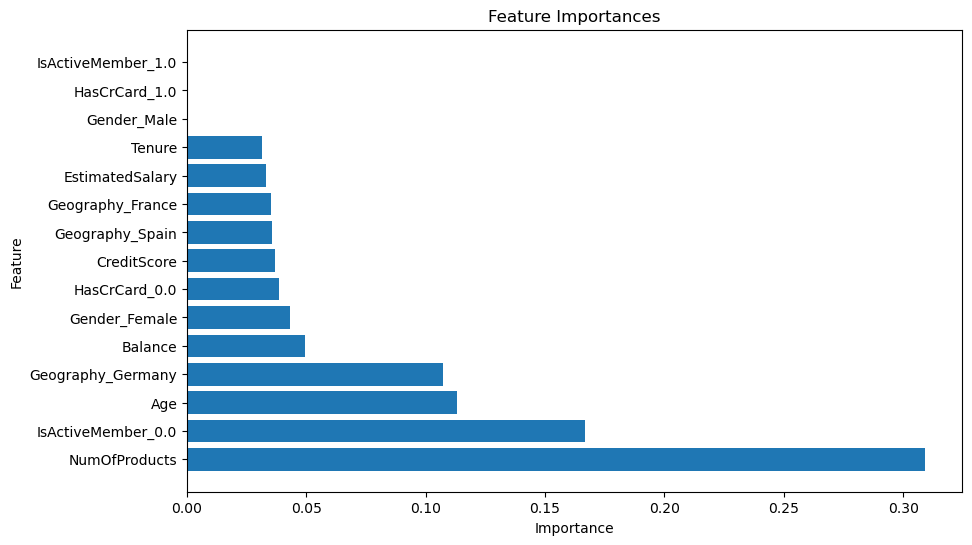

In [104]:
fi_df = fi_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(fi_df['Feature'], fi_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show;

True to what we observed during our exploratory data analysis phase, it seems that the number of products one has purchased is the most important variable in predicting whether or not a customer has left the bank, followed by their status as an active member and their age.

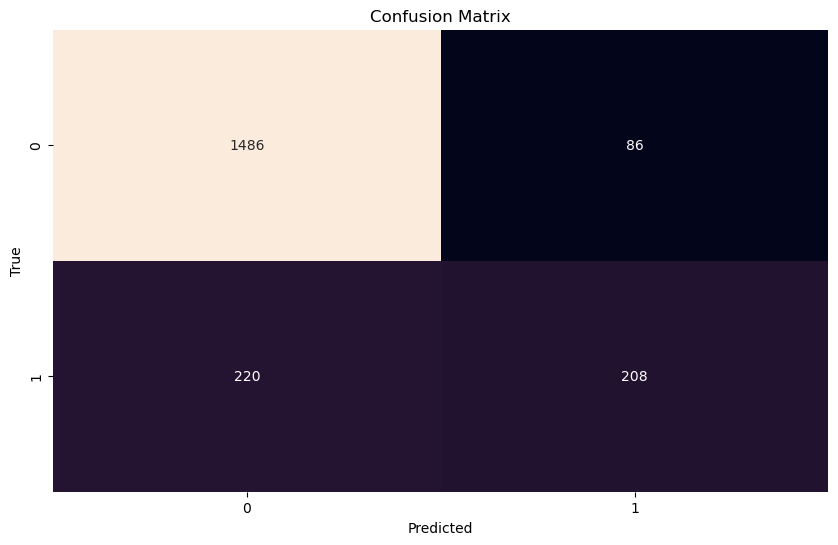

In [110]:
cf = confusion_matrix(y_val, val_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cf, annot=True, fmt='g', cmap='rocket', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

On one hand, we did fairly well in predicting the class of a given user. However, when it comes to the question of **correctly identifying someone who exited the bank** our model missed just over half of all exiters!

In [111]:
print(classification_report(y_val, val_pred))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91      1572
           1       0.71      0.49      0.58       428

    accuracy                           0.85      2000
   macro avg       0.79      0.72      0.74      2000
weighted avg       0.84      0.85      0.84      2000

